First read in the results from Runtime.hs

Each example is delimited with `__NEW_EXAMPLE__` 

In [8]:
from pathlib import Path
from matplotlib import pyplot as plt
import re
import pandas as pd
import numpy as np
import matplotlib
out_dir = Path("results")
out_dir.mkdir(exist_ok=True)

raw_results = Path("results.txt").read_text()
raw_results = raw_results.split("__START__")[-1].split("__END__")[0]
raw_results = raw_results.split("__NEW_EXAMPLE__")[1:]

In [9]:
expected_num_examples = len(list(Path("examples").glob("*")))
print(f"{len(raw_results)} examples found, expected {expected_num_examples}")


35 examples found, expected 35


Each Example has:
* `SIZE_ORIG`-> The number of AST Nodes in the original program
* `IN`-> The original program
* `SYNTH`-> The synthesized program or "ERROR" if it failed
* `SIZE_SYNTH`-> Number of AST nodes in the final synthesized program.
* `TIME` -> The amount of time it took to run 

In [11]:
def parse_example_results(example_str):
    match = re.search(
        r"SIZE_ORIG:([0-9]+)\s+IN:([\s\S]+)SYNTH:([\s\S]+)SIZE_SYNTH:([\s\S]+)TIME:(.+)",
        flags=re.MULTILINE,
        string=example_str,
    )
    assert match is not None
    size_org = int(match.group(1).strip())
    prog = match.group(2).strip()

    has_hole = "{|" in prog
    synth = match.group(3).strip()
    failed = synth == "ERROR"
    if failed:
        size_synth = -1
    else:
        size_synth = int(match.group(4).strip())
    time, unit = match.group(5).strip().split()
    time = float(time)
    if unit == "us":
        time /= 1000

    return {
            "has_hole": has_hole,
            "failed": failed,
            "size_orig": size_org,
            "program": prog,
            "synthesized": synth,
            "size_synth": size_synth,
            "time": time,
        }
    


results = list(map(parse_example_results, raw_results))
df = pd.DataFrame(results)
df_passed = df[(df["has_hole"]) & (~df["failed"])]
print("Passing:")
print(f"\tMean Time: {df_passed['time'].mean():0.2f} (+/-{df_passed['time'].std():0.2f})")
print(f"\tMean Size: {df_passed['size_synth'].mean():0.2f} (+/-{df_passed['size_synth'].std():0.2f})")
nodes_added = df_passed["size_synth"] - df_passed["size_orig"]
print(f"\tMean Nodes Added: {nodes_added.mean():0.2f} (+/-{nodes_added.std():0.2f})")
failed = df[df["failed"]]
print("Failed:")
print(f"\tMean Time: {failed['time'].mean():0.2f} (+/-{failed['time'].std():0.2f})")



Passing:
	Mean Time: 0.08 (+/-0.11)
	Mean Size: 8.85 (+/-3.60)
	Mean Nodes Added: 3.59 (+/-2.55)
Failed:
	Mean Time: 104.56 (+/-174.81)


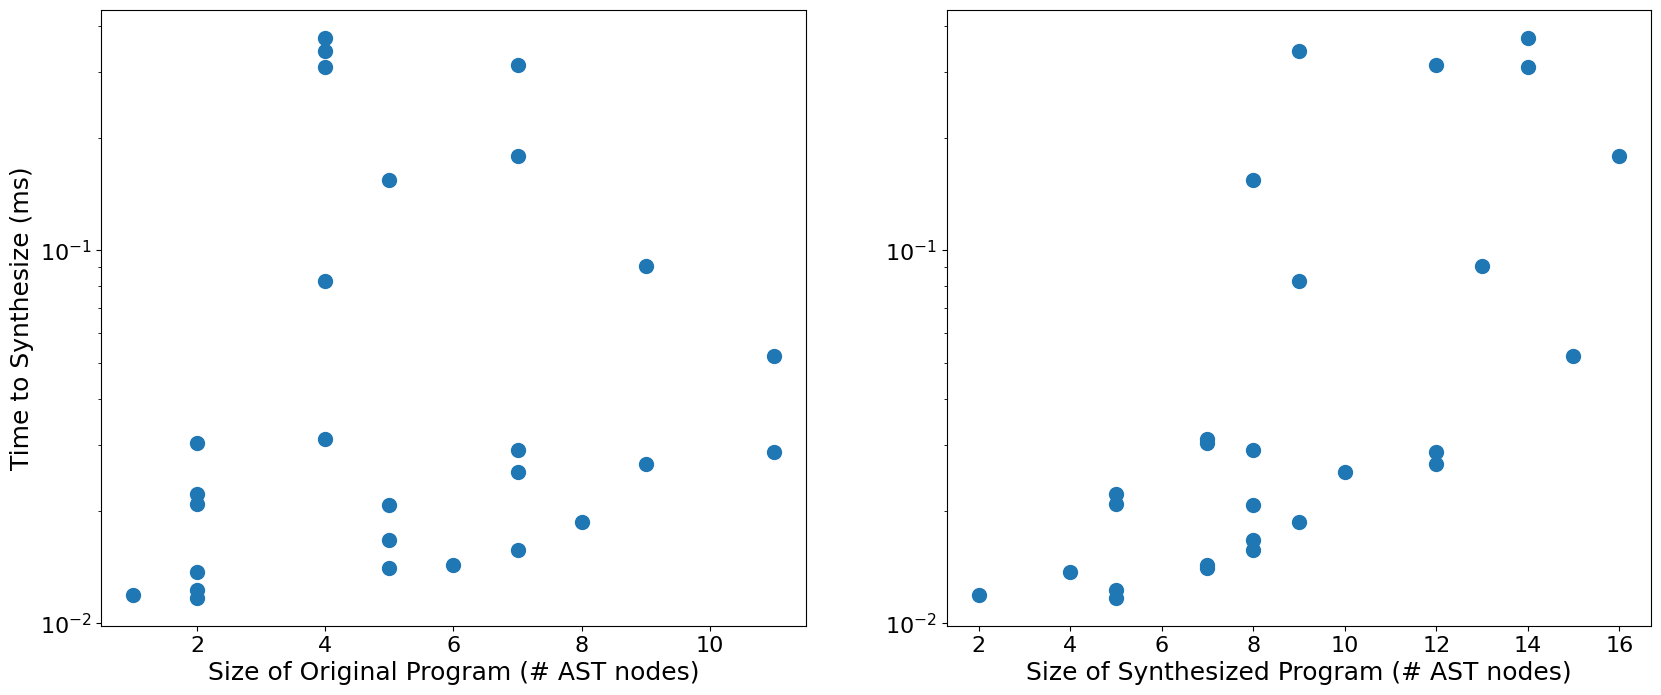

In [16]:
font = {'size': 16}

matplotlib.rc('font', **font)
fig,ax = plt.subplots(1,2,figsize=(20, 8))
ax[0].plot(df_passed["size_orig"], df_passed["time"], "o",markersize=10 )
ax[0].set_xlabel("Size of Original Program (# AST nodes)",fontsize=18)
ax[0].set_ylabel("Time to Synthesize (ms)",fontsize=18)

ax[0].set_yscale("log")
ax[1].plot(df_passed["size_synth"], df_passed["time"], "o",markersize=10)
ax[1].set_xlabel("Size of Synthesized Program (# AST nodes)",fontsize=18)
# ax[0].set_ylabel("Time to synthesize (ms)")
ax[1].set_yscale("log")

In [49]:
df.groupby("size_synth")